In [79]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
import openpyxl as xl
from datetime import timedelta
import numpy as np

/home/abbymoreno/miniconda3/envs/lacuna-fund/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [80]:
import sys

sys.path.append("../../")
from src.model_data_prep import create_outbreak_summary

# LGU Health Data Preparation

In this notebook, we will be aggregating and processing the LGU dengue dataset for one city in preparation for model development. Steps taken are:

1. Get the `start_of_week` date from each `DAdmit` (admission date) from the dataset.
2. Create bins for ages.
3. Attach PSGC codes using string matching.
4. Visualizeof cases to inspect which features we can aggregate to join for the model development.
5. Define the threshold and labeling each week as outbreak or no outbreak.

In [3]:
LGU_DIR = Path("../../data/02-raw/health/LGU/Zamboanga/")
PROCESSED_DIR = Path("../../data/03-processed/health/Zamboanga/")

ADMIN_BOUNDS = Path("../../data/01-admin-bounds/target_admin_bounds.shp")

# Load PIDSR Table

In [4]:
# load excel file and check sheet names
cases_file = xl.load_workbook(LGU_DIR / "Copy of PIDSR ARCHIVE_EpiMetrics.xlsx")
print(cases_file.sheetnames)

['ABD_', 'AES_', 'AFP_', 'AHF_', 'AMES_', 'CHOLERA_', 'ChikV_', 'DENGUE_', 'DIPH_', 'HEPATITIS_', 'HFMD_', 'ILI_', 'LEPTOSPIROSIS_', 'MALARIA_', 'MEASLES_', 'MENINGITIS_', 'MENINGO_', 'NNT_', 'NT_', 'PERT_', 'RABIES_', 'TYPHOID_']


In [5]:
# load sheet needed for pandas
# in this sample EDA we will only work with Dengue
dengue_df = pd.read_excel(
    LGU_DIR / "Copy of PIDSR ARCHIVE_EpiMetrics.xlsx", sheet_name="DENGUE_"
)
dengue_df.head(3)

,Region,Province,Muncity,AgeYears,Sex,Admitted,DAdmit,DOnset,Type,ClinClass,CaseClassification,Outcome,DateDied,Icd10Code,MorbidityMonth,MorbidityWeek,Year,Barangay
0,9,ZAMBOANGA DEL SUR,ZAMBOANGA CITY,15.083333,F,1,2013-01-05,2012-12-31,DHF,NaN,P,A,NaN,A90,1,1,2013,BOALAN
1,9,ZAMBOANGA DEL SUR,ZAMBOANGA CITY,6.583333,M,1,2013-01-02,2012-12-29,DF,NaN,S,A,NaN,A90,1,1,2013,SANTA BARBARA
2,9,ZAMBOANGA DEL SUR,ZAMBOANGA CITY,2.500000,M,1,2013-01-02,2012-12-29,DHF,NaN,S,A,NaN,NaN,1,1,2013,PASONANCA


In [6]:
# check how many weeks covered
dengue_df["MorbidityWeek"].unique()

array([ 1,  2,  3, 13,  4, 10,  9,  8,  5,  6,  7, 21, 11, 12, 31, 32, 33,
       14, 15, 16, 17, 18, 19, 20, 22, 26, 25, 24, 27, 23, 28, 30, 29, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52])

In [7]:
dengue_df.shape  # total number of cases

(25237, 18)

In [8]:
# check if no nulls on the date
# if no nulls, use as basis for start_of_week
dengue_df["DAdmit"].isna().value_counts()

False    25237
Name: DAdmit, dtype: int64

# Preprocessing LGU data 

## Add start of week date

Use hospitalization date (`DAdmit`) as basis and also this date column has no nulls.

In [9]:
dengue_df["DAdmit"] = pd.to_datetime(dengue_df["DAdmit"])

In [10]:
# Get start of the week
dengue_df["start_of_week"] = dengue_df["DAdmit"] - pd.to_timedelta(
    dengue_df["DAdmit"].dt.dayofweek, unit="D"
)

# Check if the Monday is from the previous year (December)
previous_year_mask = dengue_df["start_of_week"].dt.year < dengue_df["DAdmit"].dt.year

# Adjust the start of the week to the first day of current year
dengue_df.loc[previous_year_mask, "start_of_week"] = pd.to_datetime(
    dengue_df[previous_year_mask]["DAdmit"].dt.year, format="%Y"
)

dengue_df.head(3)

,Region,Province,Muncity,AgeYears,Sex,Admitted,DAdmit,DOnset,Type,ClinClass,CaseClassification,Outcome,DateDied,Icd10Code,MorbidityMonth,MorbidityWeek,Year,Barangay,start_of_week
0,9,ZAMBOANGA DEL SUR,ZAMBOANGA CITY,15.083333,F,1,2013-01-05,2012-12-31,DHF,NaN,P,A,NaN,A90,1,1,2013,BOALAN,2013-01-01
1,9,ZAMBOANGA DEL SUR,ZAMBOANGA CITY,6.583333,M,1,2013-01-02,2012-12-29,DF,NaN,S,A,NaN,A90,1,1,2013,SANTA BARBARA,2013-01-01
2,9,ZAMBOANGA DEL SUR,ZAMBOANGA CITY,2.500000,M,1,2013-01-02,2012-12-29,DHF,NaN,S,A,NaN,NaN,1,1,2013,PASONANCA,2013-01-01


## Bin the ages

In [11]:
bins = [0, 1, 4, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, np.inf]
names = [
    "<1",
    "1-4",
    "5-9",
    "10-14",
    "15-19",
    "20-24",
    "25-29",
    "30-34",
    "35-39",
    "40-44",
    "45-49",
    "50-54",
    "55-59",
    "60-64",
    "65-69",
    "70+",
]

dengue_df["Age_Category"] = pd.cut(dengue_df["AgeYears"], bins, labels=names)
# Manually adjust "<1" and "1-4" categories
dengue_df.loc[dengue_df["AgeYears"] == 1, "Age_Category"] = "1-4"

In [12]:
dengue_df[["AgeYears", "Age_Category"]]

,AgeYears,Age_Category
0,15.083333,15-19
1,6.583333,5-9
2,2.500000,1-4
3,7.250000,5-9
4,6.583333,5-9
...,...,...
25232,24.000000,20-24
25233,10.000000,10-14
25234,7.000000,5-9
25235,4.000000,1-4


## Attach Barangay PSGC Codes

In [13]:
aoi = gpd.read_file(ADMIN_BOUNDS)
aoi.head(2)

,ADM1_EN,ADM1_PCODE,ADM2_EN,ADM2_PCODE,ADM3_EN,ADM3_PCODE,ADM4_EN,ADM4_PCODE,geometry
0,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Lomboy,PH015518016,"POLYGON ((120.32742 16.05423, 120.32719 16.053..."
1,Region I,PH010000000,Pangasinan,PH015500000,Dagupan City,PH015518000,Tapuac,PH015518031,"POLYGON ((120.33380 16.03974, 120.33389 16.039..."


In [14]:
# Admin Boundary area columns

# List of columns to lowercase
aoi_area_cols = ["ADM2_EN", "ADM3_EN", "ADM4_EN"]

# Use applymap() to apply lowercase transformation to specified columns
aoi[aoi_area_cols] = aoi[aoi_area_cols].applymap(str.lower)

In [15]:
# There are rows with null barangay names
# keep only rows with barangays
dengue_df = dengue_df[~dengue_df["Barangay"].isna()]

In [16]:
# LGU data area columns

# List of columns to lowercase
lgu_area_cols = ["Province", "Muncity", "Barangay"]

# Use applymap() to apply lowercase transformation to specified columns
dengue_df[lgu_area_cols] = dengue_df[lgu_area_cols].applymap(str.lower)

In [17]:
dengue_df.shape

(24936, 20)

Merge raw dataset with administrative boundary dataframe by string matching on the area column names.

In [18]:
dengue_w_aoi = dengue_df.merge(aoi, left_on=lgu_area_cols, right_on=aoi_area_cols)
dengue_w_aoi = dengue_w_aoi.drop(
    columns=[
        "ADM1_EN",
        "ADM1_PCODE",
        "ADM2_EN",
        "ADM2_PCODE",
        "ADM3_EN",
        "ADM3_PCODE",
        "ADM4_EN",
        "geometry",
    ]
)
dengue_w_aoi.head(3)

,Region,Province,Muncity,AgeYears,Sex,Admitted,DAdmit,DOnset,Type,ClinClass,...,Outcome,DateDied,Icd10Code,MorbidityMonth,MorbidityWeek,Year,Barangay,start_of_week,Age_Category,ADM4_PCODE
0,9,zamboanga del sur,zamboanga city,15.083333,F,1,2013-01-05,2012-12-31,DHF,NaN,...,A,NaN,A90,1,1,2013,boalan,2013-01-01,15-19,PH097332010
1,9,zamboanga del sur,zamboanga city,6.583333,M,1,2013-01-01,2012-12-29,DSS,NaN,...,A,NaN,NaN,1,1,2013,boalan,2013-01-01,5-9,PH097332010
2,9,zamboanga del sur,zamboanga city,8.250000,F,1,2013-02-28,2013-02-25,N,NaN,...,A,NaN,A90,2,9,2013,boalan,2013-02-25,5-9,PH097332010


In [19]:
# 3 barangays unmatched, there should be 100
dengue_w_aoi["ADM4_PCODE"].nunique()

97

# Visualizations of Cases

## Number of Cases over time

In [20]:
agg_dengue_df = dengue_df.groupby(["start_of_week"]).size().reset_index(name="NumCases")
agg_dengue_df

,start_of_week,NumCases
0,2013-01-01,66
1,2013-01-07,77
2,2013-01-14,83
3,2013-01-21,75
4,2013-01-28,85
...,...,...
470,2021-11-29,27
471,2021-12-06,26
472,2021-12-13,35
473,2021-12-20,27


In [21]:
# Check 75th percentile value
agg_dengue_df.describe()

,NumCases
count,475.000000
mean,52.496842
std,53.738128
min,1.000000
25%,16.500000
50%,41.000000
75%,71.000000
max,391.000000


Plot all cases over time with the possible threshold.

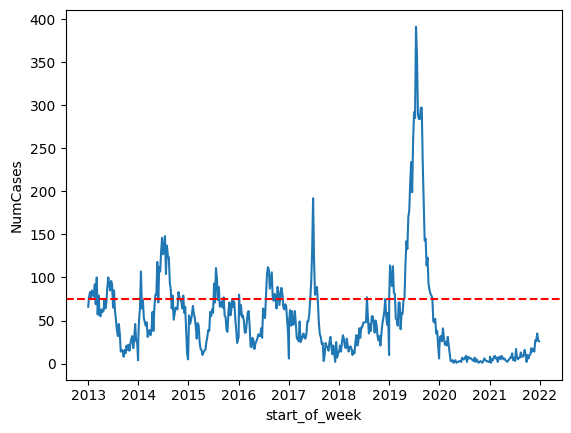

In [22]:
sns.lineplot(x="start_of_week", y="NumCases", data=agg_dengue_df)

# Add a horizontal line for the threshold
sample_threshold = 75
plt.axhline(sample_threshold, color="red", linestyle="--", label="Threshold")
# Show the plot
plt.show()

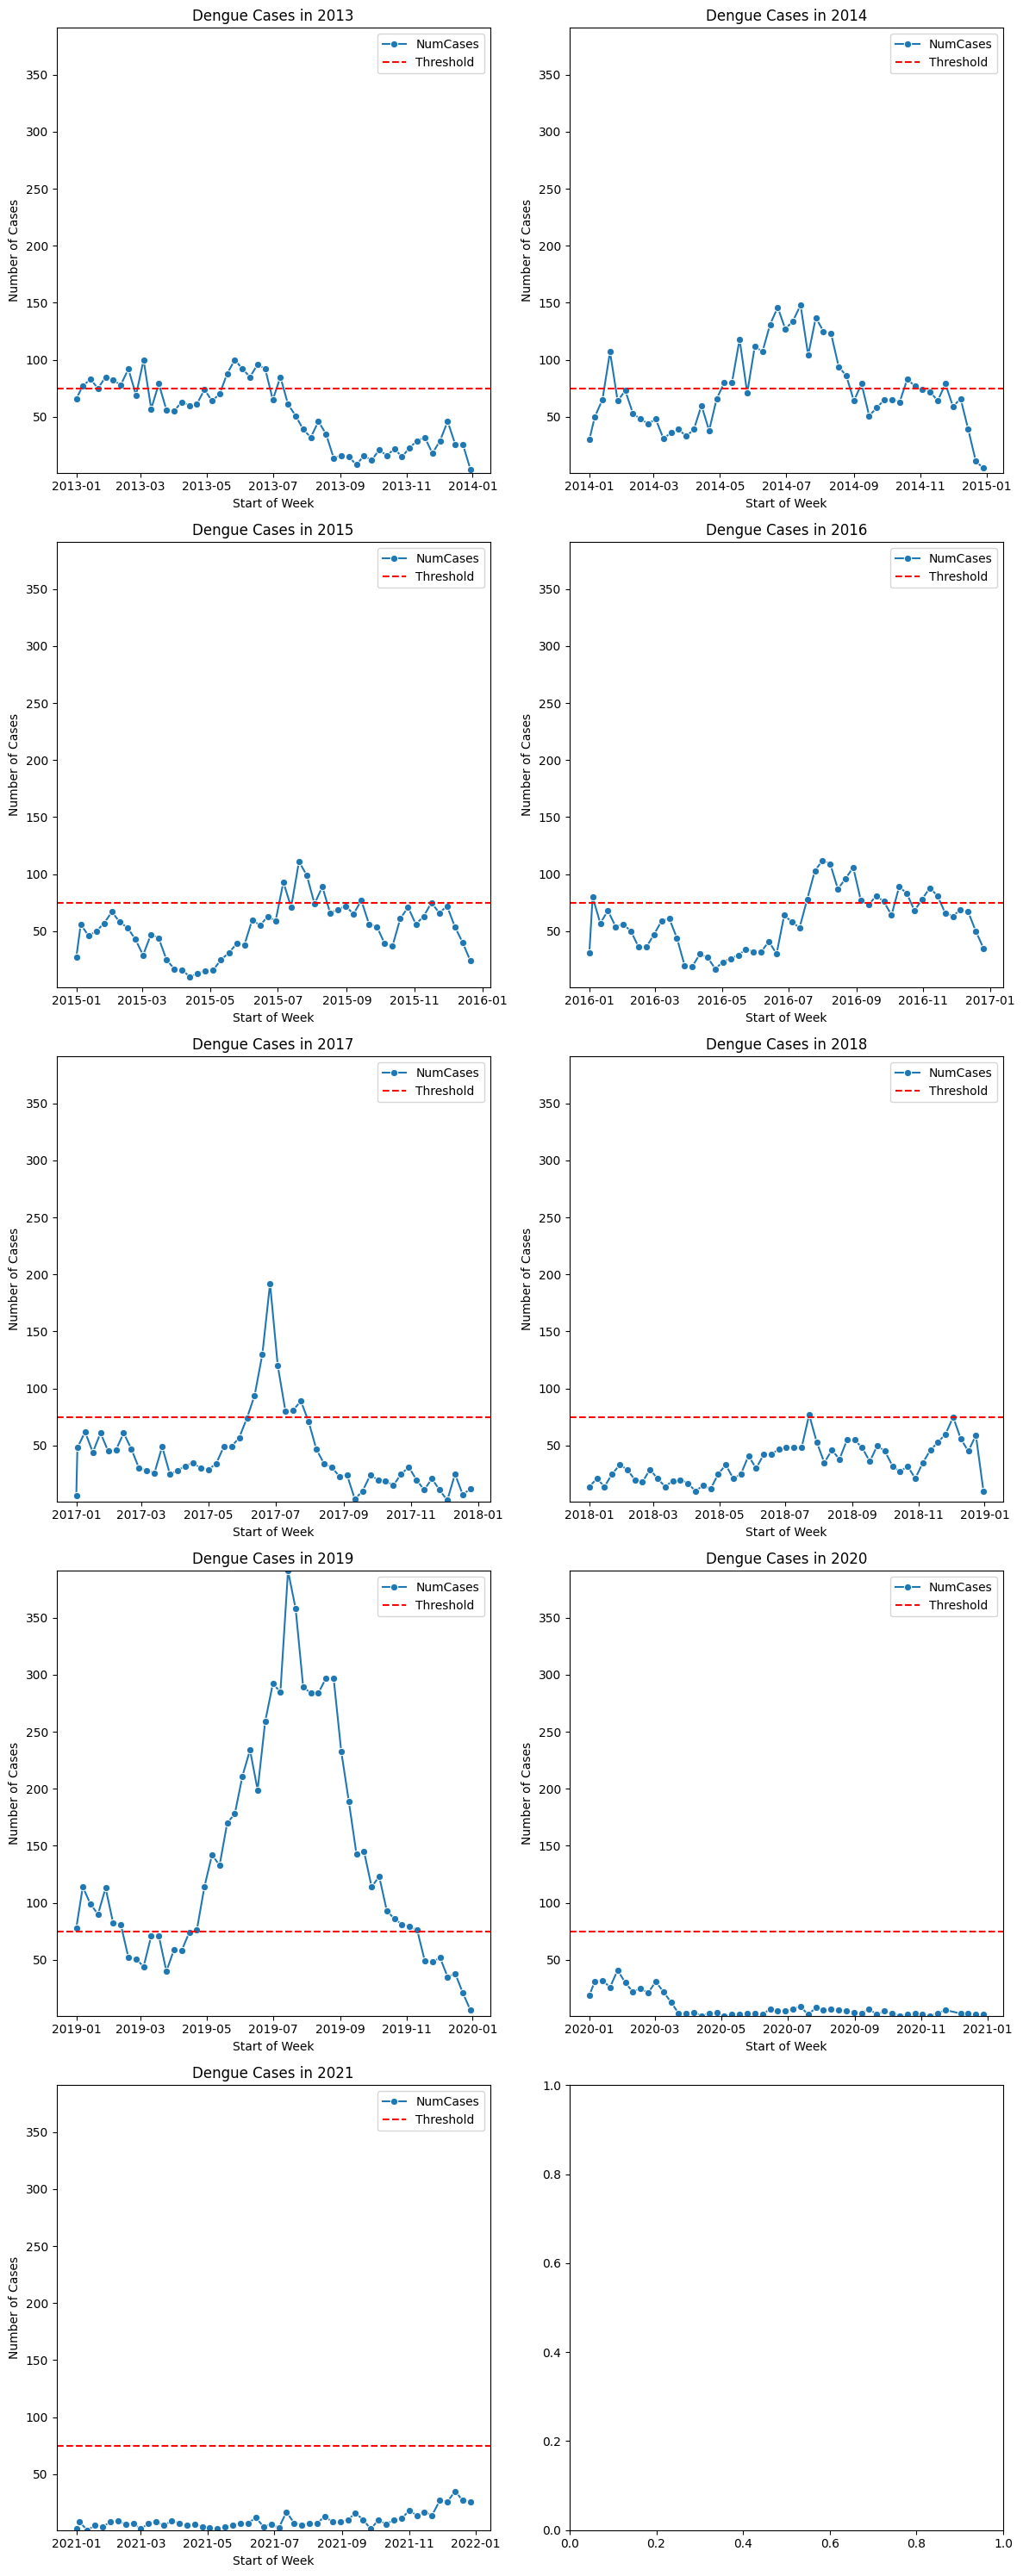

In [23]:
# Extract unique years from the 'start_of_week' column
years = agg_dengue_df["start_of_week"].dt.year.unique()

y_min = agg_dengue_df["NumCases"].min()
y_max = agg_dengue_df["NumCases"].max()

# Calculate the number of rows and columns for subplots
num_rows = len(years) // 2 + (len(years) % 2)  # Adjust for odd number of years
num_cols = 2

# Create a single figure with subplots arranged in two columns
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 6 * num_rows))

# Flatten the axes array for ease of indexing
axes = axes.flatten()

for i, year in enumerate(years):
    ax = axes[i]
    if i >= len(years):
        ax.axis("off")  # Turn off unused subplots
        continue

    ax.set_title(f"Dengue Cases in {year}")

    # Filter the data for the current year
    year_data = agg_dengue_df[agg_dengue_df["start_of_week"].dt.year == year]

    # Create a Seaborn line plot for the current year's data
    sns.lineplot(
        x="start_of_week",
        y="NumCases",
        data=year_data,
        marker="o",
        label="NumCases",
        ax=ax,
    )

    # Add a horizontal line for the threshold
    ax.axhline(sample_threshold, color="red", linestyle="--", label="Threshold")
    ax.set_ylim(y_min, y_max)

    # Customize the plot
    ax.set_xlabel("Start of Week")
    ax.set_ylabel("Number of Cases")
    ax.legend()

# Adjust the layout to prevent overlap of subplots
plt.tight_layout()

# Show the combined figure with subplots
plt.show()

## Trends of cases per sex

Check if there will be a difference in trend for age groups. If no difference, then proceed as is with aggregation of cases. If there is a difference, then might need to consider creating a separate model.

In [24]:
agg_sex_dengue_df = (
    dengue_df.groupby(["start_of_week", "Sex"]).size().reset_index(name="NumCases")
)
agg_sex_dengue_df

,start_of_week,Sex,NumCases
0,2013-01-01,F,28
1,2013-01-01,M,38
2,2013-01-07,F,34
3,2013-01-07,M,43
4,2013-01-14,F,38
...,...,...,...
928,2021-12-13,M,18
929,2021-12-20,F,13
930,2021-12-20,M,14
931,2021-12-27,F,13


Different sex does not vary on the historical trend. No need for separate models.

<Axes: xlabel='start_of_week', ylabel='NumCases'>

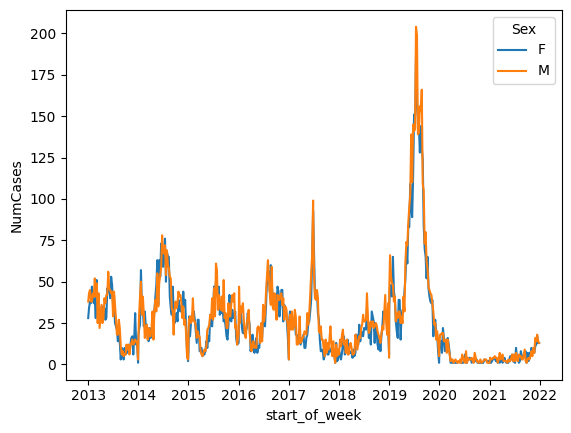

In [25]:
sns.lineplot(x="start_of_week", y="NumCases", hue="Sex", data=agg_sex_dengue_df)

## Plot by Age group

Check if trends would vary for different age groups.

In [26]:
dengue_df["Age_Category"].value_counts()

5-9      6146
10-14    4787
1-4      3683
15-19    3431
20-24    1947
25-29    1235
30-34     798
<1        635
35-39     527
40-44     408
45-49     299
50-54     267
55-59     212
70+       203
60-64     185
65-69     146
Name: Age_Category, dtype: int64

In [27]:
# Group by start of week date and age bin
agg_age_dengue_df = (
    dengue_df.groupby(["start_of_week", "Age_Category"])
    .size()
    .reset_index(name="NumCases")
)
agg_age_dengue_df.head(3)

,start_of_week,Age_Category,NumCases
0,2013-01-01,<1,2
1,2013-01-01,1-4,4
2,2013-01-01,5-9,14


Based on the plot, an outbreak would only occur in year 2019 for limited age groups only. Shows that no need to have separate model for varying ages.

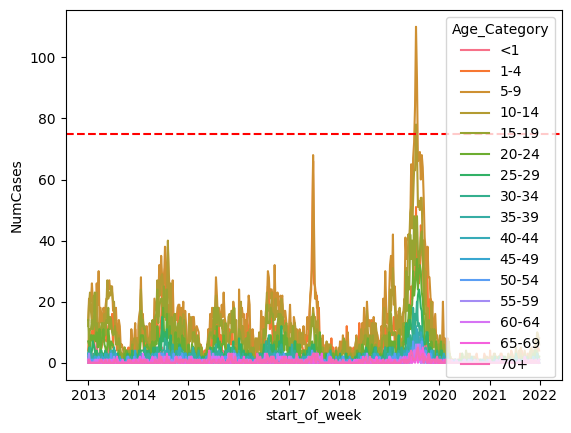

In [28]:
sns.lineplot(
    x="start_of_week", y="NumCases", hue="Age_Category", data=agg_age_dengue_df
)
plt.axhline(sample_threshold, color="red", linestyle="--", label="Threshold")
plt.show()

# Setting the definition of an outbreak

We define an outbreak as follows:

1. The **start** of an outbreak occurs when the week's cases equal to or higher than a threshold. 

    - The **threshold** is defined as the 75th percentile of weekly cases based on years when a substantial number of cases are recorded. 

2. The **end** of an outbreak occurs during the week when cases fall below the threshold for at least 2 weeks.

The chosen threshold is **71** cases.

In [30]:
agg_week_dengue = (
    dengue_w_aoi.groupby(["start_of_week"]).size().reset_index(name="NumCases")
)
agg_week_dengue["NumCases"].describe()

count    475.000000
mean      52.492632
std       53.738088
min        1.000000
25%       16.500000
50%       41.000000
75%       71.000000
max      391.000000
Name: NumCases, dtype: float64

# Preparing Aggregated Table (Brgy-Weekly)

In [54]:
# working only with one city file, just group by date
city_weekly = (
    dengue_w_aoi.groupby(["start_of_week"]).size().reset_index(name="NumCases")
)
city_weekly.head(3)

,start_of_week,NumCases
0,2013-01-01,66
1,2013-01-07,77
2,2013-01-14,83


In [55]:
city_weekly.shape

(475, 2)

In [56]:
city_weekly

,start_of_week,NumCases
0,2013-01-01,66
1,2013-01-07,77
2,2013-01-14,83
3,2013-01-21,75
4,2013-01-28,85
...,...,...
470,2021-11-29,27
471,2021-12-06,26
472,2021-12-13,35
473,2021-12-20,27


## Add missing weekly dates

In [58]:
# Create a complete date range with weekly frequency
complete_date_range = pd.date_range(start="2013-01-01", end="2021-12-31", freq="W-MON")

# Convert your DataFrame to have a MultiIndex
city_weekly = city_weekly.set_index(["start_of_week"])

# Create a DataFrame with the complete date range
complete_dates_df = pd.DataFrame({"start_of_week": complete_date_range})

# Merge with the original DataFrame to insert missing dates
city_weekly = pd.merge(city_weekly, complete_dates_df, on="start_of_week", how="left")

# Fill missing values in 'ADM4_PCODE' and 'NumCases' columns
city_weekly["NumCases"].fillna(0, inplace=True)

In [57]:
complete_date_range

DatetimeIndex(['2013-01-07', '2013-01-14', '2013-01-21', '2013-01-28',
               '2013-02-04', '2013-02-11', '2013-02-18', '2013-02-25',
               '2013-03-04', '2013-03-11',
               ...
               '2021-10-25', '2021-11-01', '2021-11-08', '2021-11-15',
               '2021-11-22', '2021-11-29', '2021-12-06', '2021-12-13',
               '2021-12-20', '2021-12-27'],
              dtype='datetime64[ns]', length=469, freq='W-MON')

In [59]:
city_weekly.shape

(475, 2)

In [60]:
city_weekly

,start_of_week,NumCases
0,2013-01-01,66
1,2013-01-07,77
2,2013-01-14,83
3,2013-01-21,75
4,2013-01-28,85
...,...,...
470,2021-11-29,27
471,2021-12-06,26
472,2021-12-13,35
473,2021-12-20,27


In [67]:
city_weekly[city_weekly["NumCases"] == 0]

,start_of_week,NumCases


## Add sex and age groups as additional features

In [61]:
# compute for age statistics
agg_age_dengue_df = (
    dengue_w_aoi.groupby(["start_of_week"])
    .agg(
        {
            "AgeYears": ["min", "max", "mean", "median", "std"],
        }
    )
    .reset_index()
)

agg_age_dengue_df.columns = ["start_of_week"] + [
    f"Age_{stat}" for stat in ["min", "max", "mean", "median", "std"]
]

agg_age_dengue_df.head()

,start_of_week,Age_min,Age_max,Age_mean,Age_median,Age_std
0,2013-01-01,0.500000,68.083333,17.587121,14.750000,14.592766
1,2013-01-07,0.416667,72.083333,15.054113,10.416667,15.442763
2,2013-01-14,0.666667,45.000000,13.447791,11.333333,10.454911
3,2013-01-21,0.416667,49.583333,12.897778,10.250000,9.506395
4,2013-01-28,0.250000,49.583333,12.851961,11.333333,9.896491


In [62]:
# aggregate number of cases based on sex
agg_sex_dengue_df = (
    dengue_w_aoi.groupby(["start_of_week", "Sex"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
    .rename_axis(columns=None)
)
# Rename the columns for clarity
agg_sex_dengue_df.columns = ["start_of_week", "Female", "Male"]
agg_sex_dengue_df.head()

,start_of_week,Female,Male
0,2013-01-01,28,38
1,2013-01-07,34,43
2,2013-01-14,38,45
3,2013-01-21,37,38
4,2013-01-28,47,38


In [64]:
# merge additional features into one table
agg_age_sex_df = agg_age_dengue_df.merge(agg_sex_dengue_df, on=["start_of_week"])
agg_age_sex_df.head()

,start_of_week,Age_min,Age_max,Age_mean,Age_median,Age_std,Female,Male
0,2013-01-01,0.500000,68.083333,17.587121,14.750000,14.592766,28,38
1,2013-01-07,0.416667,72.083333,15.054113,10.416667,15.442763,34,43
2,2013-01-14,0.666667,45.000000,13.447791,11.333333,10.454911,38,45
3,2013-01-21,0.416667,49.583333,12.897778,10.250000,9.506395,37,38
4,2013-01-28,0.250000,49.583333,12.851961,11.333333,9.896491,47,38


In [66]:
# join with the brgy_weekly with complete dates
city_weekly_w_feat = city_weekly.merge(agg_age_sex_df, on=["start_of_week"], how="left")
city_weekly_w_feat.head()

,start_of_week,NumCases,Age_min,Age_max,Age_mean,Age_median,Age_std,Female,Male
0,2013-01-01,66,0.500000,68.083333,17.587121,14.750000,14.592766,28,38
1,2013-01-07,77,0.416667,72.083333,15.054113,10.416667,15.442763,34,43
2,2013-01-14,83,0.666667,45.000000,13.447791,11.333333,10.454911,38,45
3,2013-01-21,75,0.416667,49.583333,12.897778,10.250000,9.506395,37,38
4,2013-01-28,85,0.250000,49.583333,12.851961,11.333333,9.896491,47,38


In [68]:
# total number of points
city_weekly_w_feat.shape

(475, 9)

# Labeling data based on threshold definition

In [70]:
# Set your threshold value
OUTBREAK_THRESHOLD = 71

# Create a new column 'outbreak' initialized with zeros
city_weekly_w_feat["outbreak"] = 0

# grouped = city_weekly_w_feat.groupby(["start_of_week", "ADM4_PCODE"])["NumCases"].sum()
# Track consecutive weeks below threshold within each group
# for (timestamp, barangay), total_cases in grouped.iteritems():
#     group = brgy_weekly_w_feat[(brgy_weekly_w_feat["ADM4_PCODE"] == barangay)]

consecutive_weeks_below_threshold = 0
previous_outbreak = False

for index, row in city_weekly_w_feat.iterrows():
    if row["NumCases"] > OUTBREAK_THRESHOLD:
        consecutive_weeks_below_threshold = 0
        previous_outbreak = True
        city_weekly_w_feat.at[index, "outbreak"] = 1
    else:
        # check if previous week was an outbreak
        # if yes, continue to tag current week as outbreak
        # part of observation period
        if previous_outbreak and consecutive_weeks_below_threshold < 2:
            city_weekly_w_feat.at[index, "outbreak"] = 1
            consecutive_weeks_below_threshold += 1
        elif consecutive_weeks_below_threshold == 2:
            city_weekly_w_feat.at[index, "outbreak"] = 0
            previous_outbreak = False
        else:
            city_weekly_w_feat.at[index, "outbreak"] = 0

In [72]:
city_weekly_w_feat.head()

,start_of_week,NumCases,Age_min,Age_max,Age_mean,Age_median,Age_std,Female,Male,outbreak
0,2013-01-01,66,0.500000,68.083333,17.587121,14.750000,14.592766,28,38,0
1,2013-01-07,77,0.416667,72.083333,15.054113,10.416667,15.442763,34,43,1
2,2013-01-14,83,0.666667,45.000000,13.447791,11.333333,10.454911,38,45,1
3,2013-01-21,75,0.416667,49.583333,12.897778,10.250000,9.506395,37,38,1
4,2013-01-28,85,0.250000,49.583333,12.851961,11.333333,9.896491,47,38,1


In [73]:
city_weekly_w_feat.to_csv(
    PROCESSED_DIR / "city_weekly_zamboanga_labeled_v1.csv", index=False
)

In [74]:
city_weekly_w_feat["outbreak"].value_counts(dropna=False)

0    316
1    159
Name: outbreak, dtype: int64

## Inspect labeled data

Jumps in the lineplots can be ignored. Sudden jumps just indicate a change in the outbreak label.

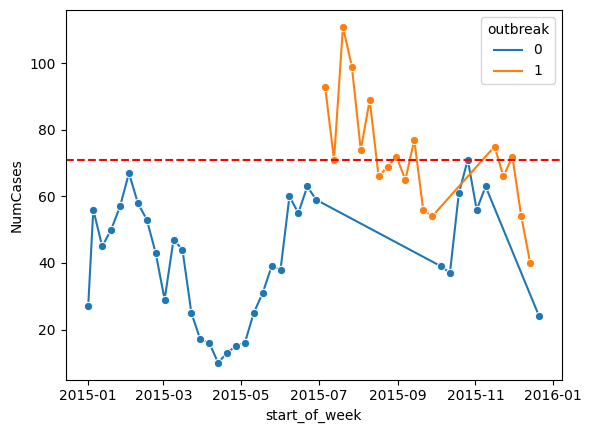

In [76]:
sns.lineplot(
    x="start_of_week",
    y="NumCases",
    data=city_weekly_w_feat[(city_weekly_w_feat["start_of_week"].dt.year == 2015)],
    hue="outbreak",
    marker="o",
)

# Add a horizontal line for the threshold
plt.axhline(71, color="red", linestyle="--", label="Threshold")
# Show the plot
plt.show()

## Get Outbreaks Summary table

In [82]:
summary_city = create_outbreak_summary(city_weekly_w_feat, "outbreak")
summary_city

,outbreak_group,start_date,end_date,actual_length_weeks
0,1,2013-01-07,2013-04-01,13
1,3,2013-04-29,2013-07-22,13
2,5,2014-01-20,2014-02-17,5
3,7,2014-05-05,2014-09-22,21
4,9,2014-10-20,2014-12-08,8
5,11,2015-07-06,2015-09-28,13
6,13,2015-11-16,2015-12-14,5
7,15,2016-01-04,2016-01-18,3
8,17,2016-07-18,2016-11-28,20
9,19,2017-06-05,2017-08-07,10


In [83]:
summary_city.to_csv(LGU_DIR / "outbreaks_city_weekly_zamboanga_v1.csv", index=False)